In [17]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

from ast import literal_eval
import collections
from mimic_common import *
import os
import pandas as pd
from statistics import mean, stdev

In [54]:
def read_plot(group_name, group_1, group_2, eval_metric):
    """ 
    Read the dataframe and plot
    """

    score_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_OT.csv")
    score_df = pd.read_csv(score_path, header=0, index_col=None)

    plt.figure()
    sc = plt.scatter(score_df['label_div_score'], score_df['wa_dist'], c=score_df[f'trans_target_{eval_metric}'], s=5)
    plt.title(f'Source: {group_1} \n Target: {group_2}')
    plt.colorbar(sc)
    plt.xlabel('labeling divergence score')
    plt.ylabel('Wasserstein distance')
    plt.show()

    plt.figure()
    plt.scatter(score_df['label_div_score'], score_df[f'trans_target_{eval_metric}'], s=5)
    plt.title(f'Source: {group_1} \n Target: {group_2}')
    plt.xlabel('labeling divergence score')
    plt.ylabel('rmse')
    plt.show()


    plt.figure()
    plt.scatter(score_df['wa_dist'], score_df[f'trans_target_{eval_metric}'], s=5)
    plt.title(f'Source: {group_1} \n Target: {group_2}')
    plt.xlabel('Wasserstein distance')
    plt.ylabel('rmse')
    plt.show()

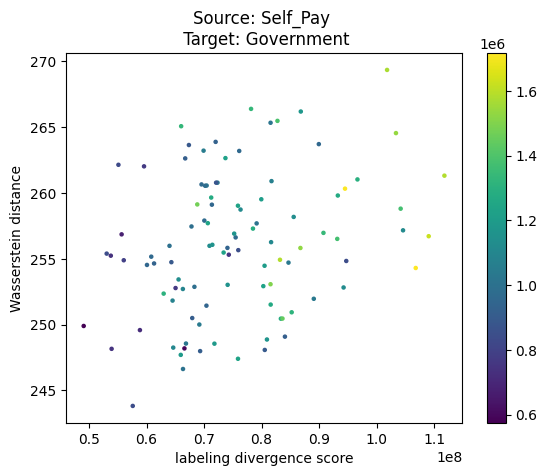

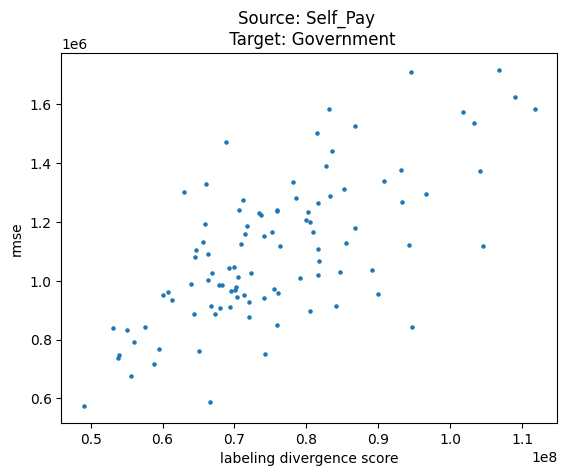

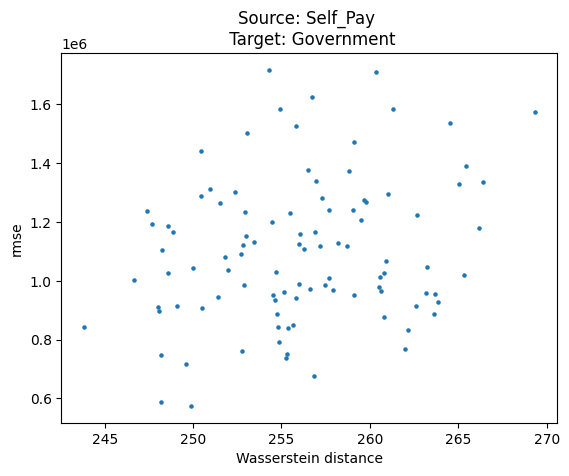

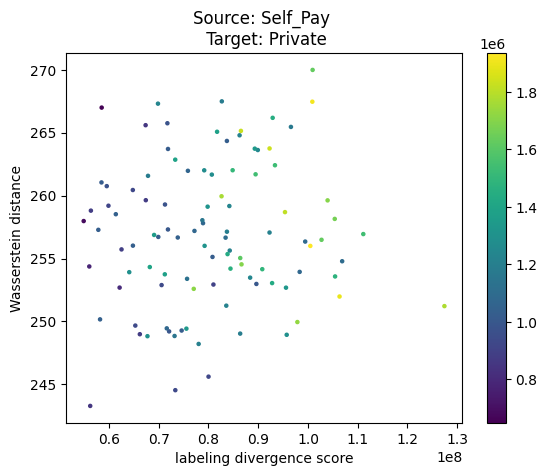

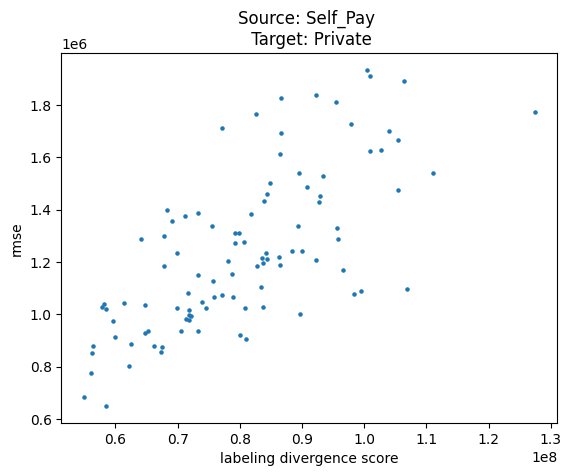

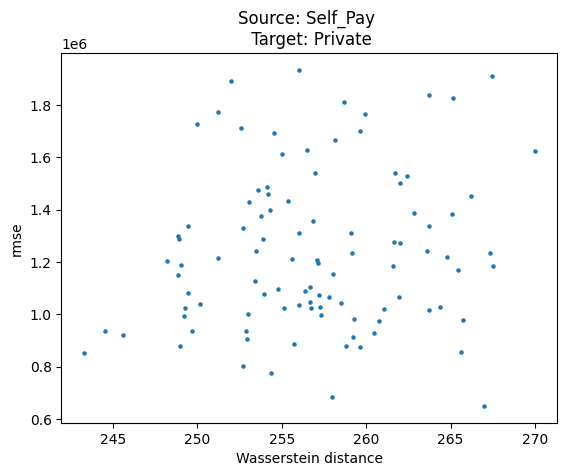

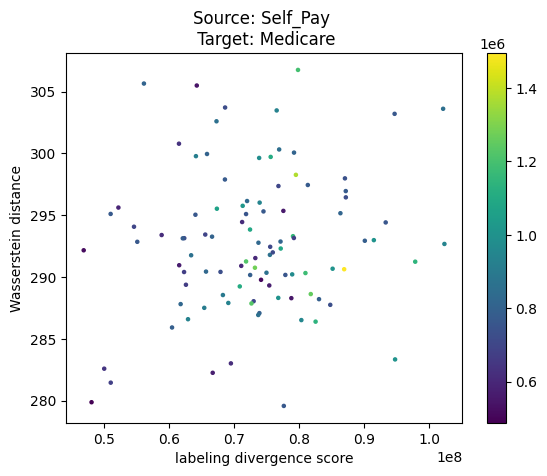

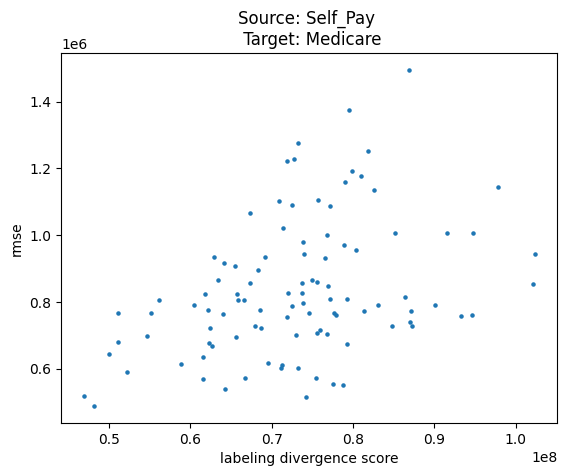

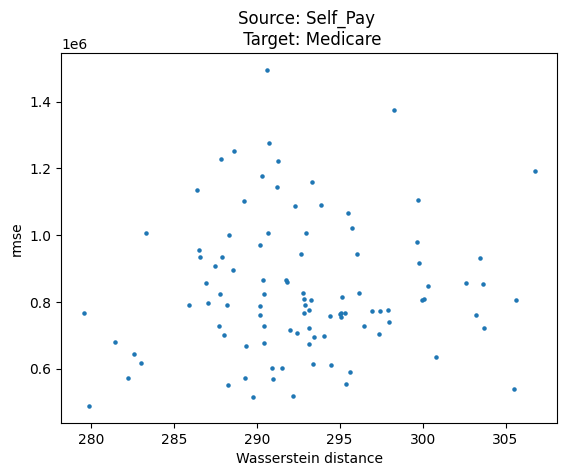

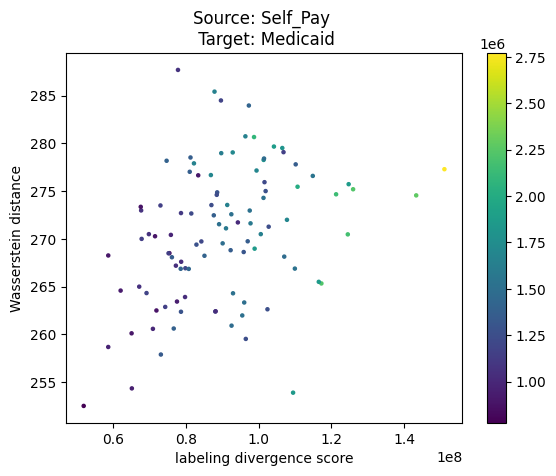

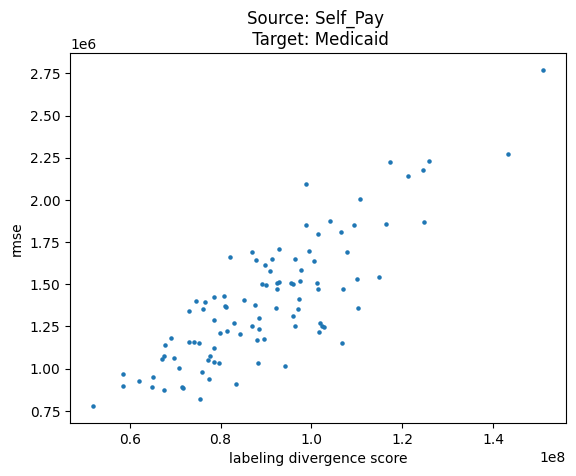

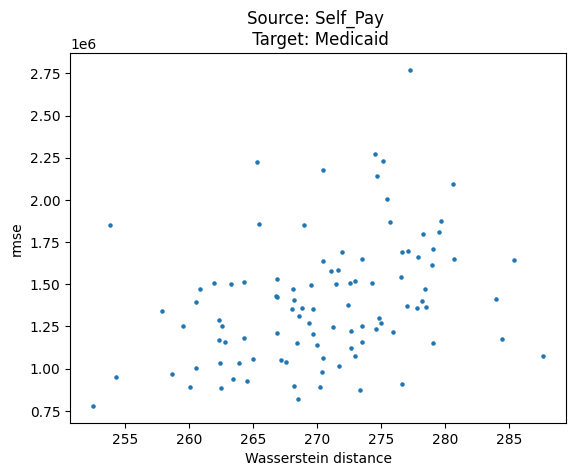

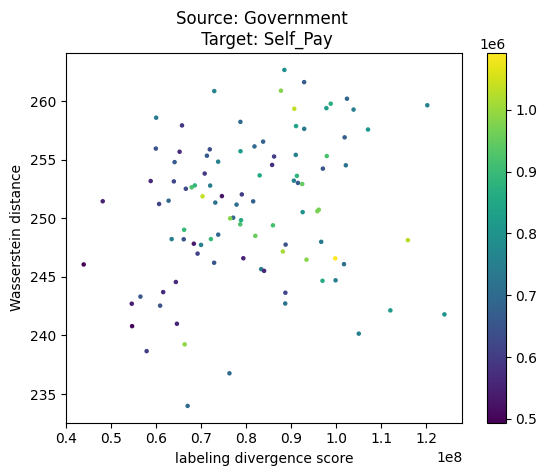

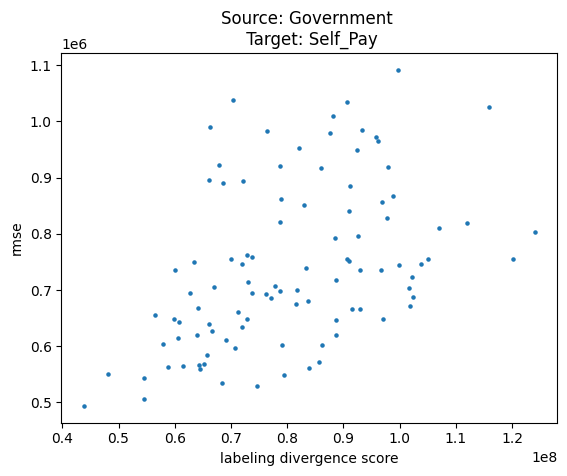

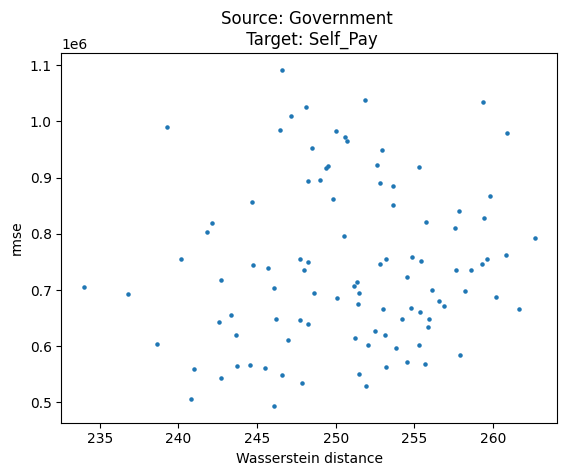

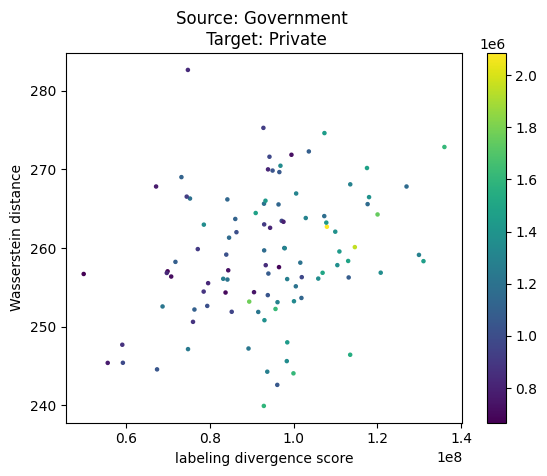

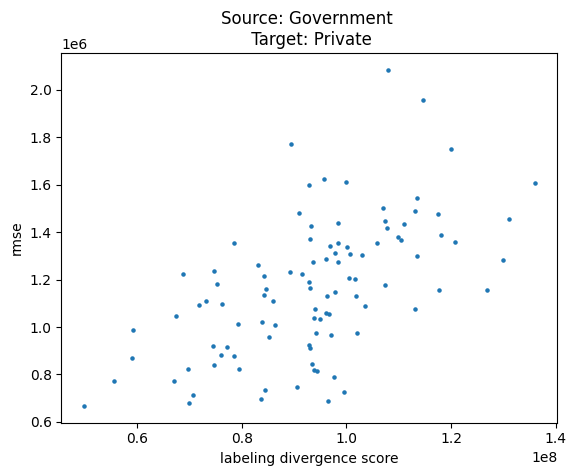

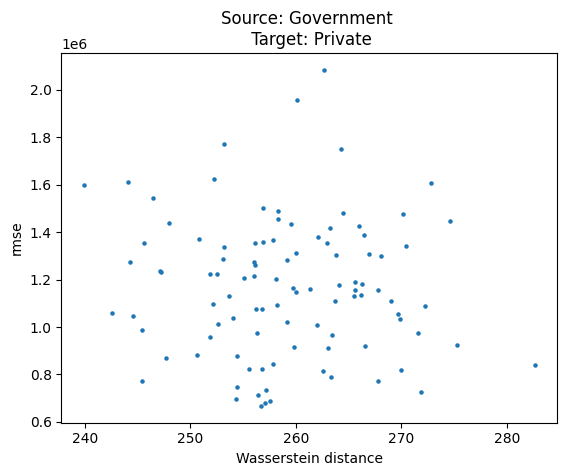

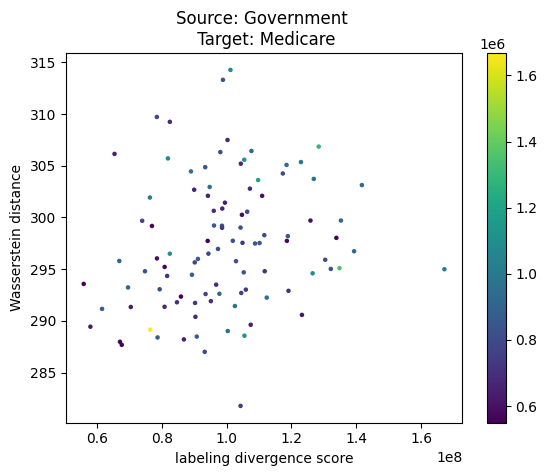

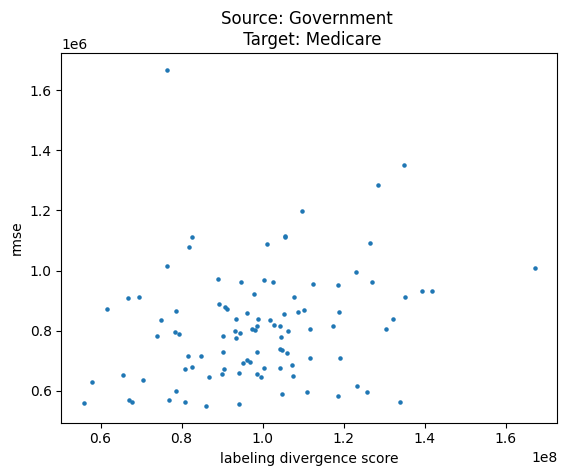

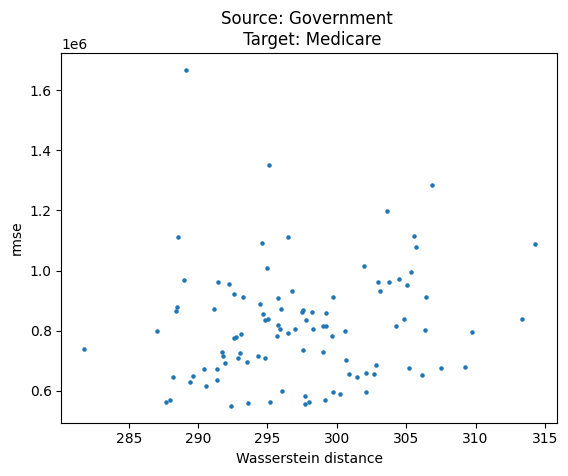

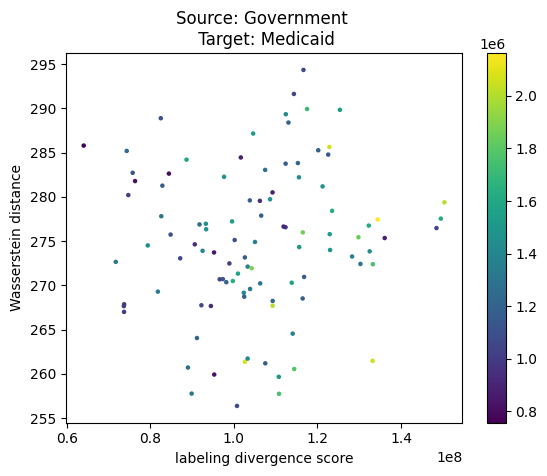

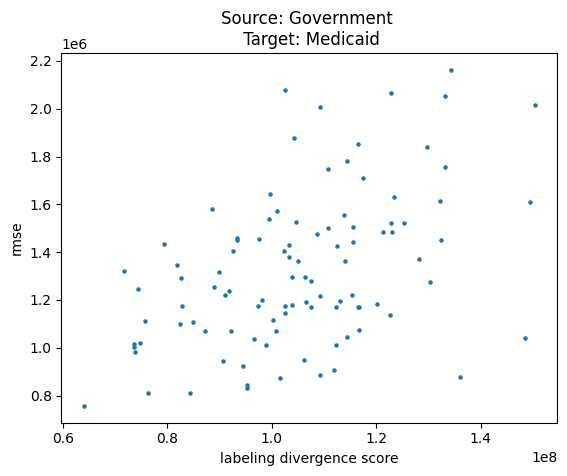

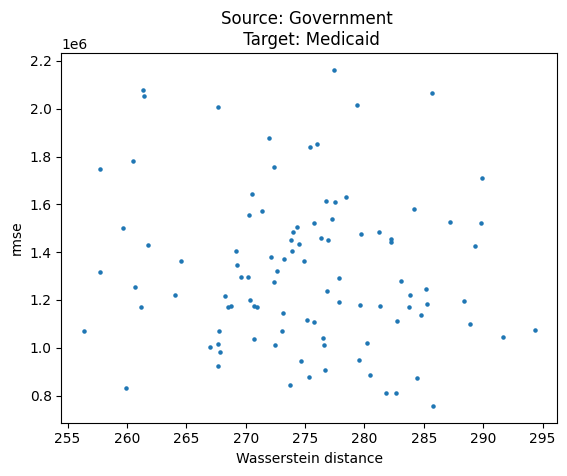

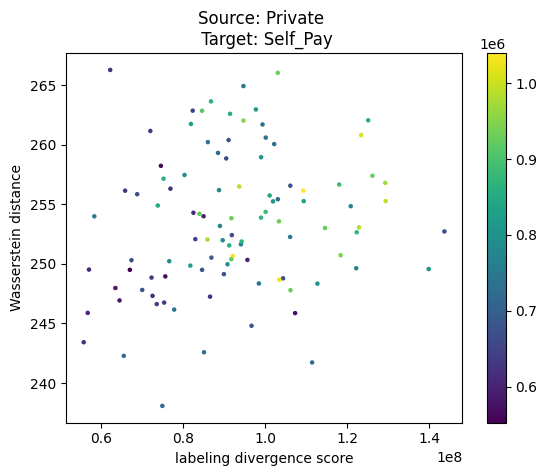

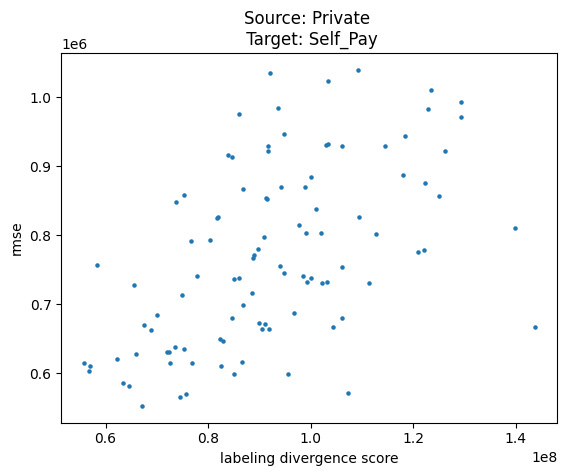

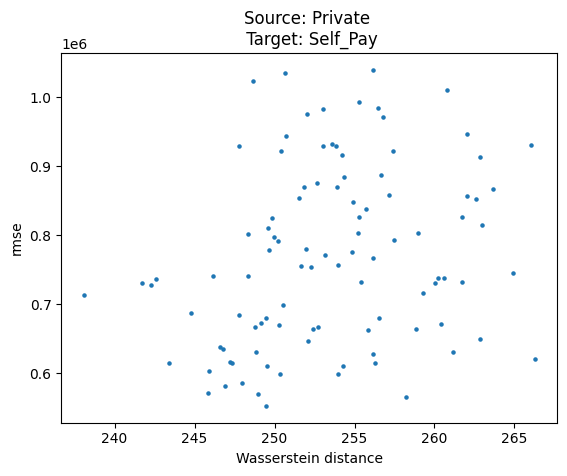

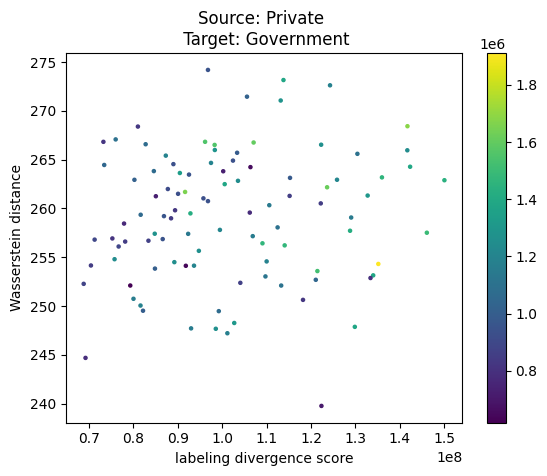

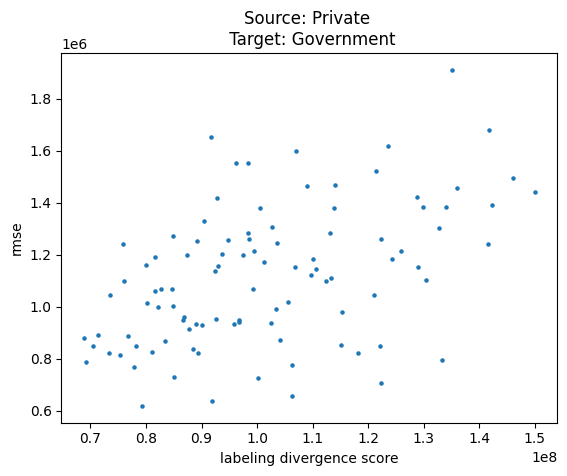

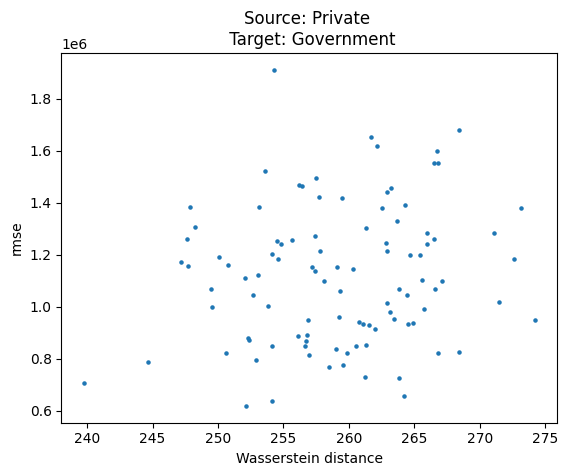

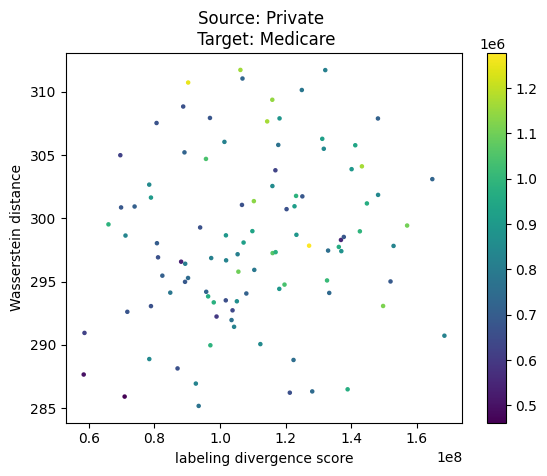

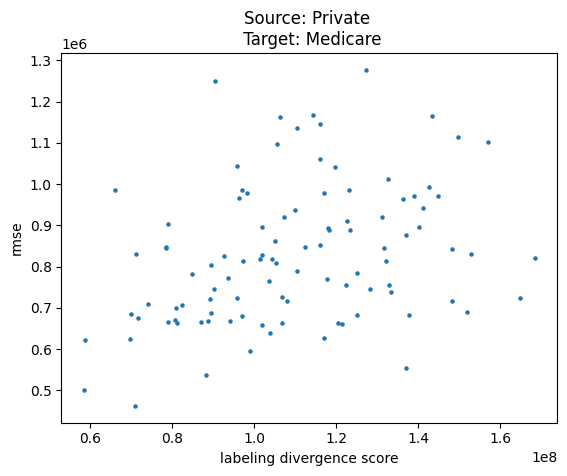

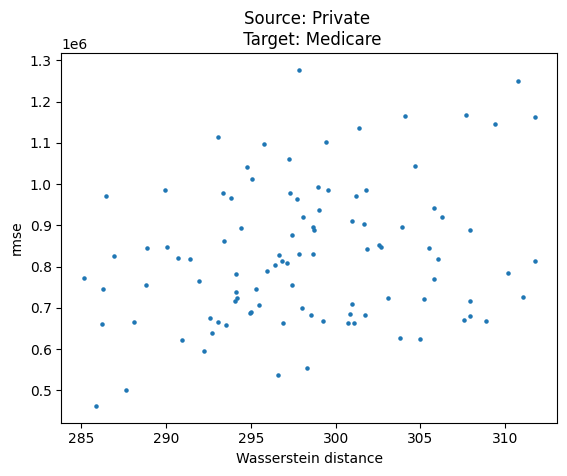

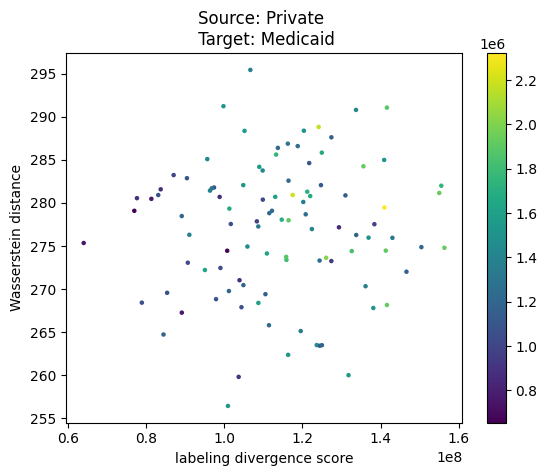

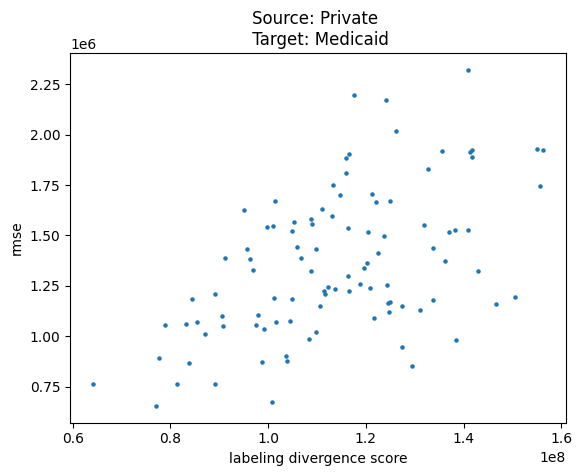

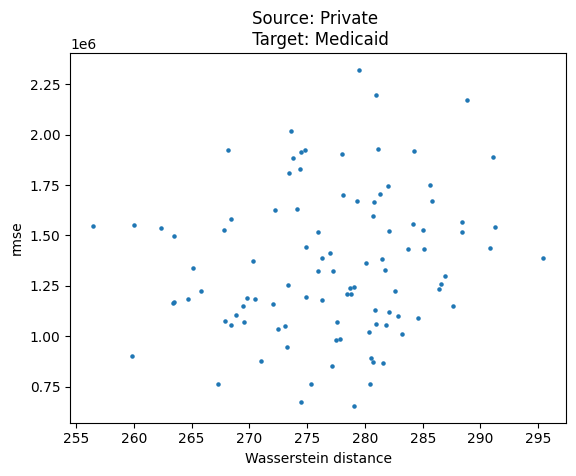

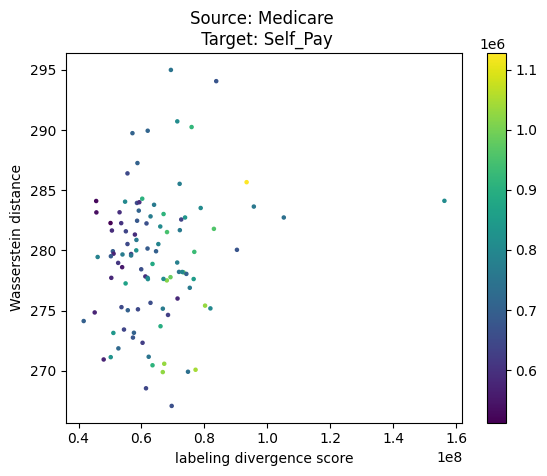

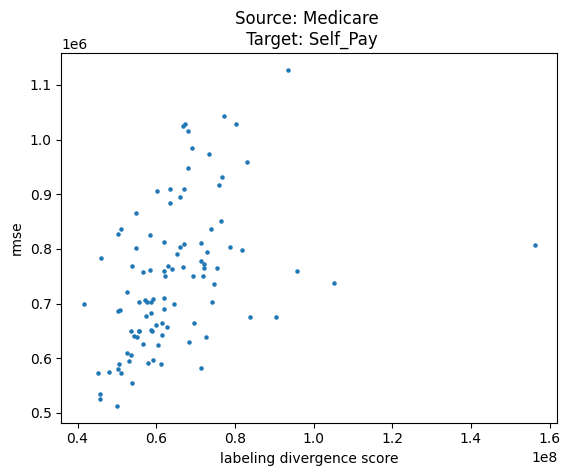

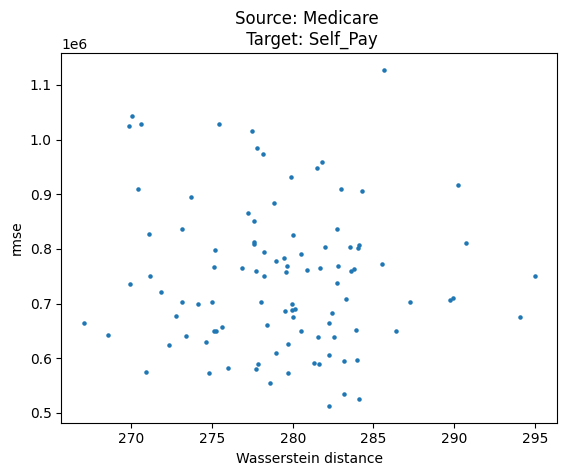

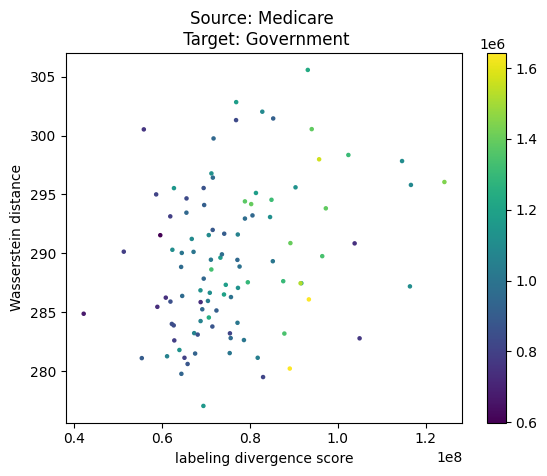

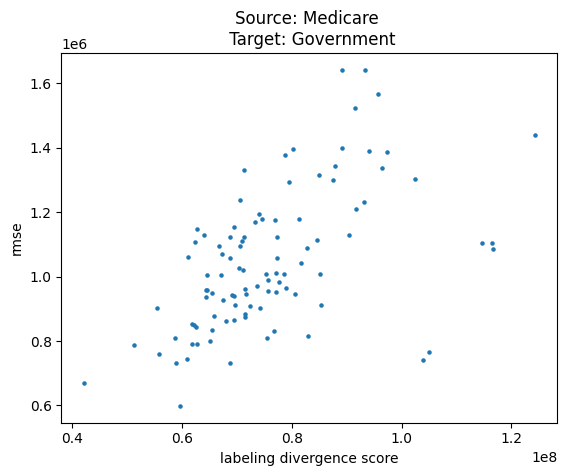

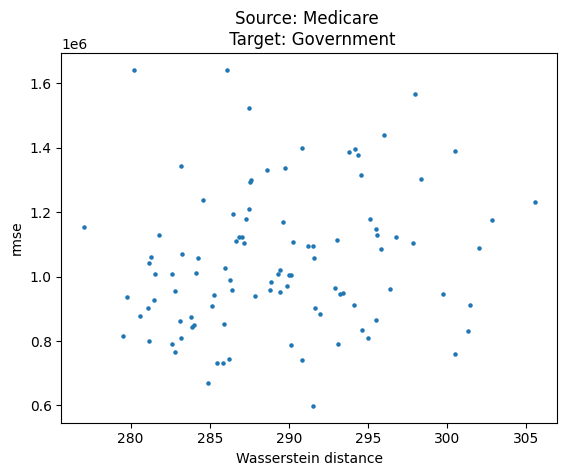

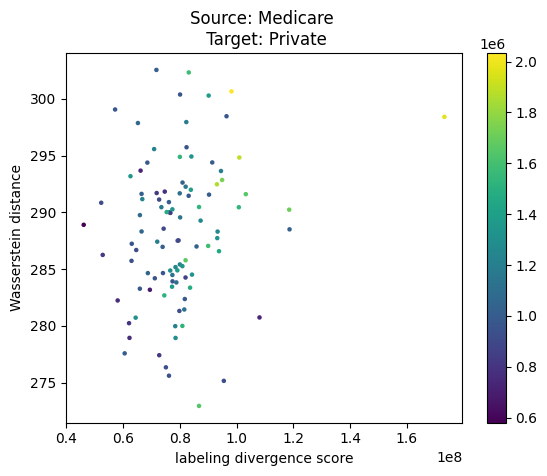

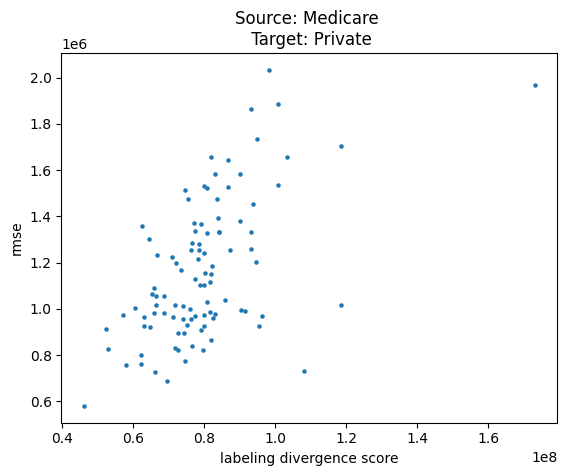

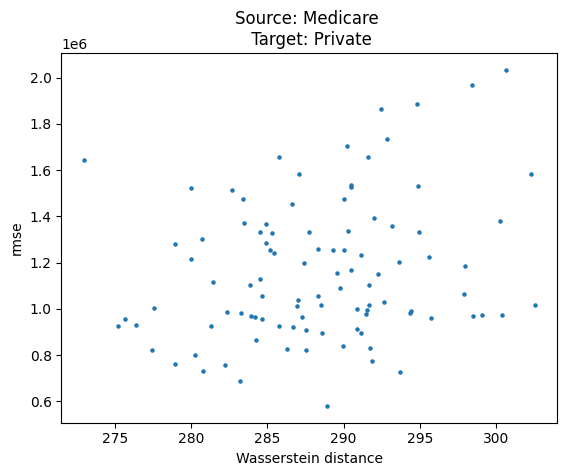

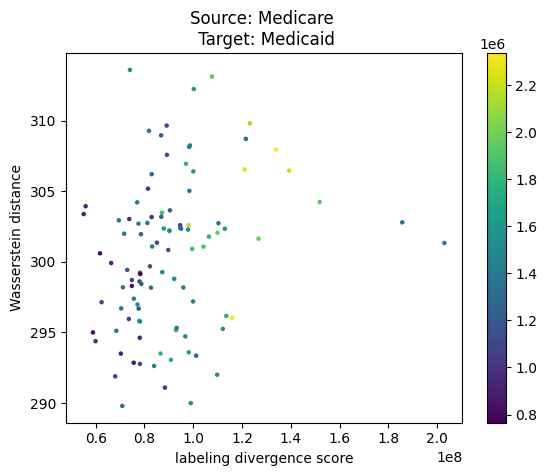

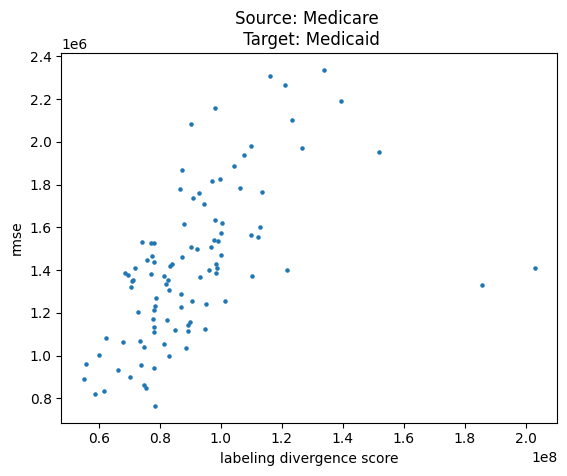

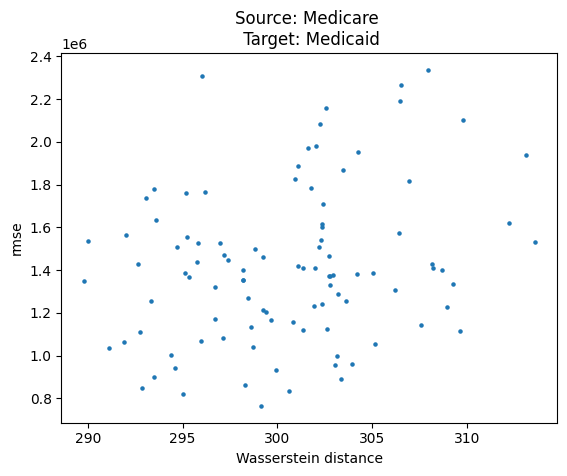

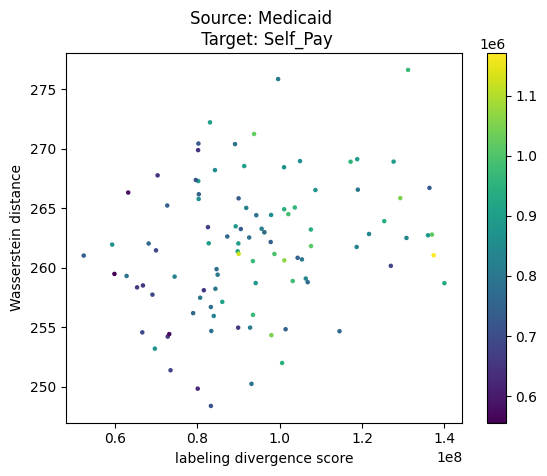

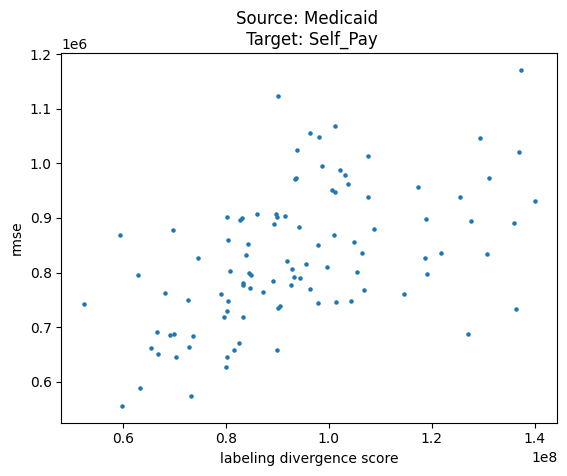

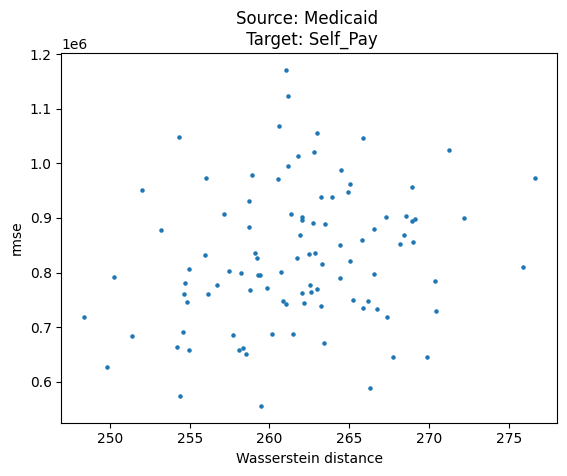

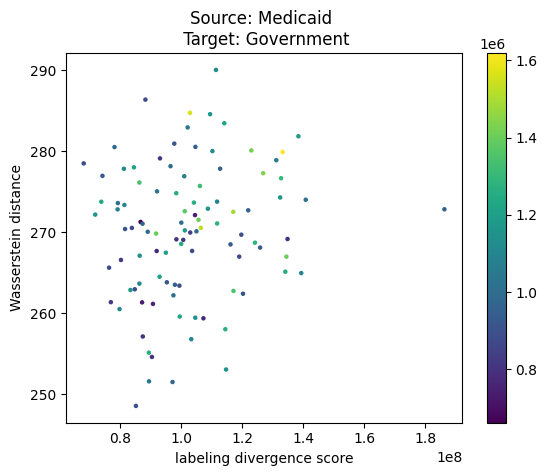

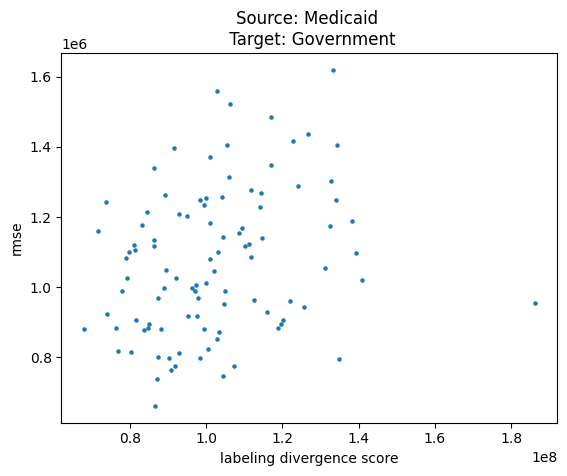

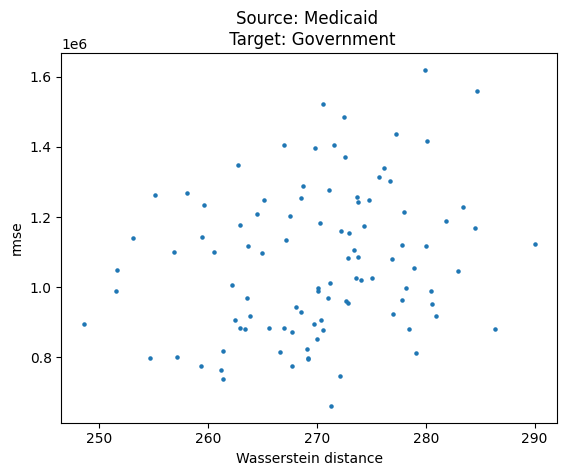

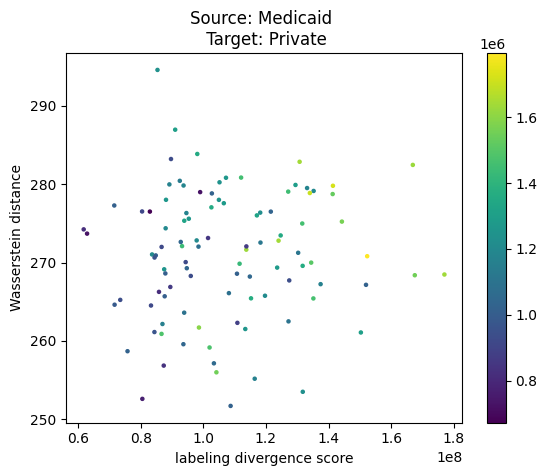

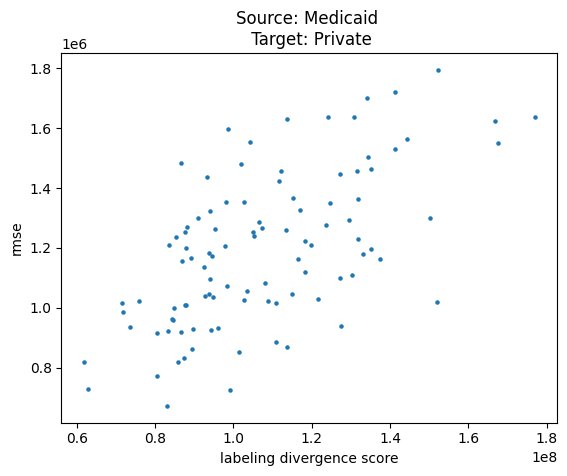

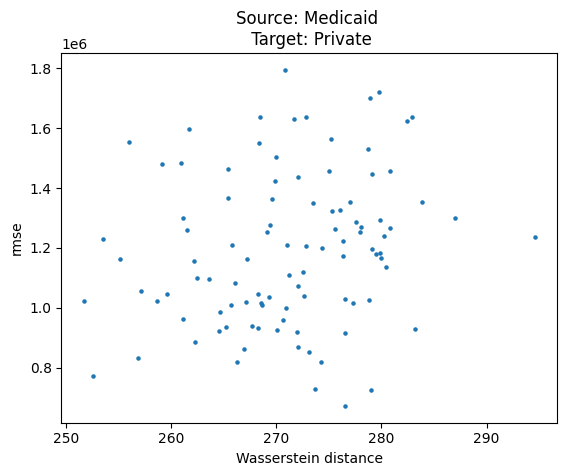

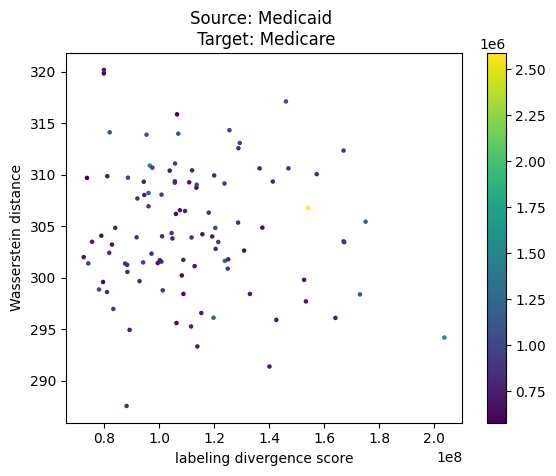

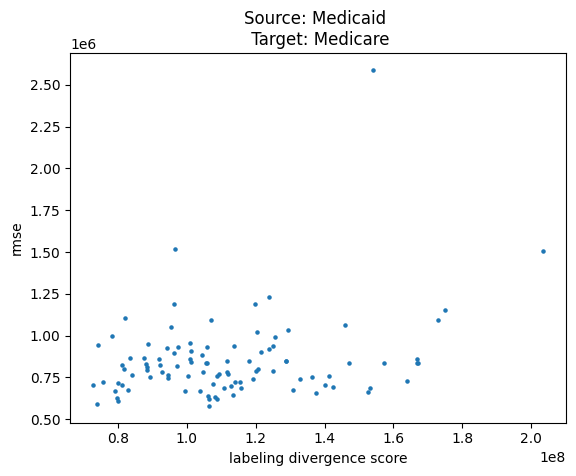

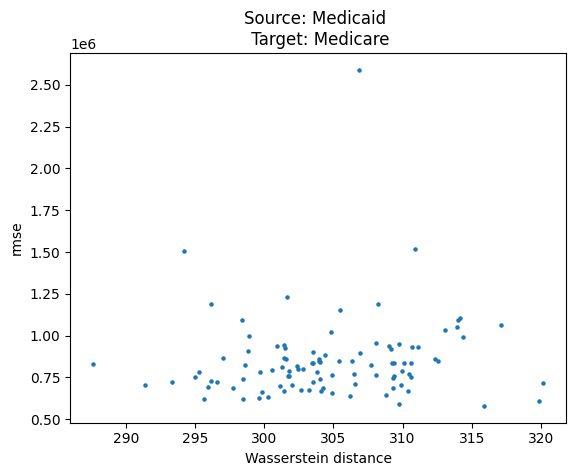

In [55]:
group_name = 'insurance'
groups = ['Self_Pay', 'Government', 'Private',  'Medicare', 'Medicaid']
eval_metric = 'rmse'
for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue
        read_plot(group_name, group_1, group_2, eval_metric)


In [8]:
group_name = "insurance"
group_1 = 'Medicare'
group_2 = 'Medicaid'
score_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_OT.csv")
score_df = pd.read_csv(score_path, header=0, index_col=None)
score_df


,source_mae,source_mse,source_rmse,target_mae,target_mse,target_rmse,trans_target_mae,trans_target_mse,trans_target_rmse,label_div_score,wa_dist
0,381689.770853,2.155273e+11,464249.150284,8.247153e+05,1.310195e+12,1.144638e+06,7.534874e+05,1.230250e+12,1.109166e+06,7.812433e+07,292.771215
1,324315.477972,2.012353e+11,448592.617779,8.002374e+05,1.873807e+12,1.368871e+06,7.534091e+05,1.926298e+12,1.387912e+06,6.846584e+07,295.112635
2,263991.527633,1.151570e+11,339347.939612,8.122851e+05,2.307752e+12,1.519129e+06,7.705035e+05,2.147947e+12,1.465588e+06,7.754298e+07,302.698042
3,421177.248137,4.837049e+11,695488.995428,1.276205e+06,5.533462e+12,2.352331e+06,1.047856e+06,5.130164e+12,2.264987e+06,1.211107e+08,306.540518
4,259139.930541,1.317908e+11,363029.991205,6.720920e+05,9.618352e+11,9.807320e+05,6.120253e+05,9.206938e+11,9.595279e+05,5.588485e+07,303.933124
...,...,...,...,...,...,...,...,...,...,...,...
95,246702.242370,9.531323e+10,308728.406990,8.156210e+05,2.526820e+12,1.589597e+06,7.278117e+05,2.329422e+12,1.526244e+06,7.714584e+07,296.975594
96,390640.084711,2.901515e+11,538657.132323,8.789280e+05,3.376668e+12,1.837571e+06,7.482947e+05,2.606617e+12,1.614502e+06,8.795461e+07,302.355667
97,282940.306952,1.467728e+11,383109.434280,1.024515e+06,2.418284e+12,1.555083e+06,8.455751e+05,1.875944e+12,1.369651e+06,9.320379e+07,295.315474
98,383294.964121,3.019865e+11,549532.976995,9.288489e+05,2.052008e+12,1.432483e+06,7.496592e+05,1.513034e+12,1.230054e+06,8.685430e+07,308.950066


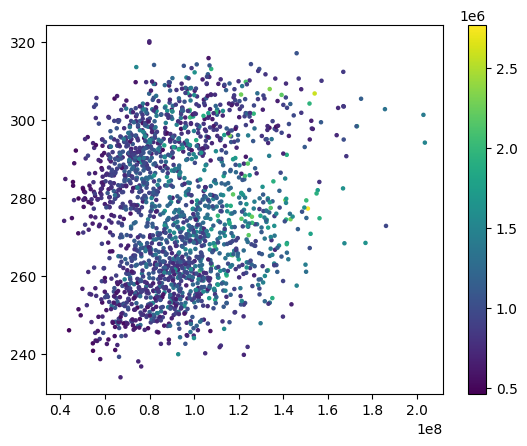

In [39]:
eval_metric = 'rmse'
# metric_ratios = np.divide(score_df[f'trans_target_{eval_metric}']score_df[f'target_{eval_metric}'], score_df[f'target_{eval_metric}'])
sc = plt.scatter(combined_df['label_div_score'], combined_df['wa_dist'], c=combined_df[f'trans_target_{eval_metric}'], s=5)
plt.colorbar(sc)
plt.show()

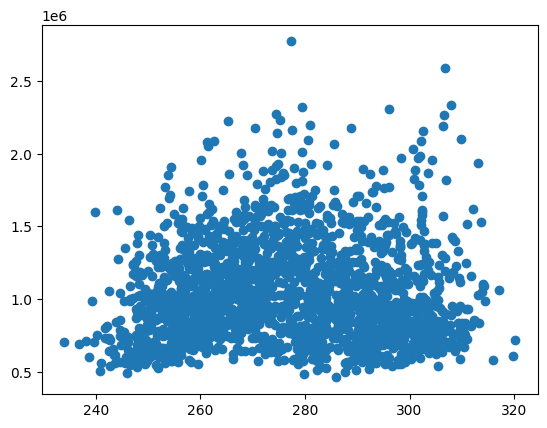

In [37]:
plt.scatter(combined_df['wa_dist'], combined_df[f'trans_target_{eval_metric}'])
plt.show()